In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, RBF
from mbbo.output import format_for_submission
from mbbo.functions import get_function_data, FunctionInfo
import mbbo.kernels
%load_ext autoreload
%autoreload 2

Text(0.5, 0, 'Output')

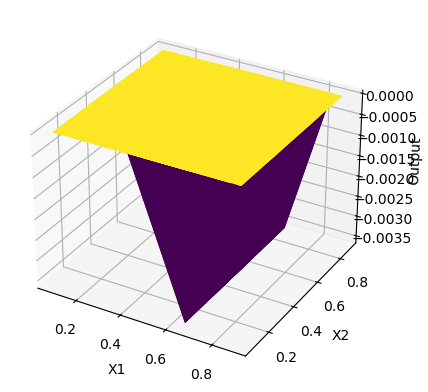

In [2]:
#mesh plot
ary1_in = np.load('../data/raw/initial_data/function_1/initial_inputs.npy')
ary1_out = np.load('../data/raw/initial_data/function_1/initial_outputs.npy')

x = ary1_in[:, 0]
y = ary1_in[:, 1]

X, Y = np.meshgrid(x, y)

# Reshape the output to fit the meshgrid layout for the surface plot
Z = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        Z[j, i] = ary1_out[i]  


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Surface plot
ax.plot_surface(X, Y, Z, cmap='viridis')

# Set labels
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Output')

In [3]:
random.seed(51)
np.random.seed(51)


In [4]:
#Output to CSV
interim_folder = '../data/interim'
for i in range(1,9):
    ary_in, ary_out = get_function_data(i)
    combined = np.append(ary_in, ary_out.reshape(-1,1), axis=1)
    np.savetxt(f'{interim_folder}/function_{i}.csv', combined, delimiter=',')



In [5]:
f1_in, f1_out = get_function_data(1)
f1_out_scaled = mbbo.functions.scale_f1(f1_out) 
for original, scaled in zip(f1_out ,f1_out_scaled):
    print(f"Original: {original:.2E} -> Scaled: {scaled:.4f}")

Original: 1.32E-79 -> Scaled: 0.2262
Original: 1.03E-46 -> Scaled: 0.5592
Original: 7.71E-16 -> Scaled: 0.8717
Original: 3.34E-124 -> Scaled: 0.2253
Original: -3.61E-03 -> Scaled: -1.0000
Original: -2.16E-54 -> Scaled: -0.4814
Original: -2.09E-91 -> Scaled: -0.1067
Original: 2.54E-40 -> Scaled: 0.6239
Original: 3.61E-81 -> Scaled: 0.2104
Original: 6.23E-48 -> Scaled: 0.5468
Original: 0.00E+00 -> Scaled: 0.0000
Original: -1.21E-18 -> Scaled: -0.8433
Original: -2.12E-95 -> Scaled: -0.0663
Original: -8.31E-27 -> Scaled: -0.7607
Original: 1.52E-192 -> Scaled: 0.9172
Original: -1.78E-113 -> Scaled: -0.1167
Original: 5.71E-181 -> Scaled: 0.8000
Original: 1.52E-192 -> Scaled: 0.9172


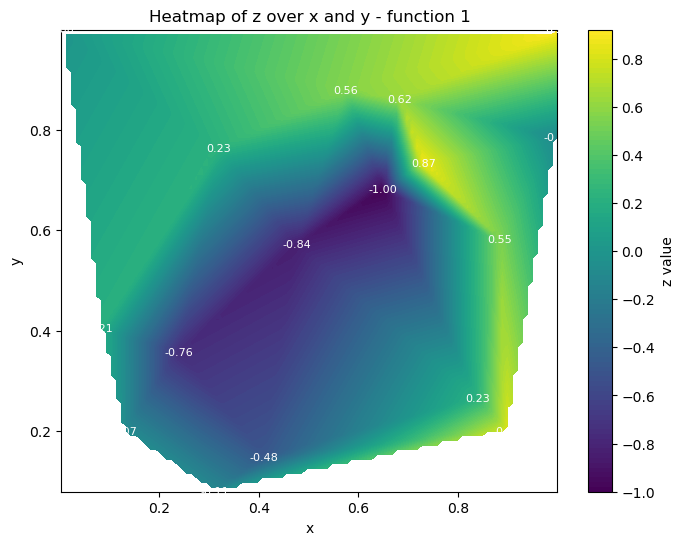

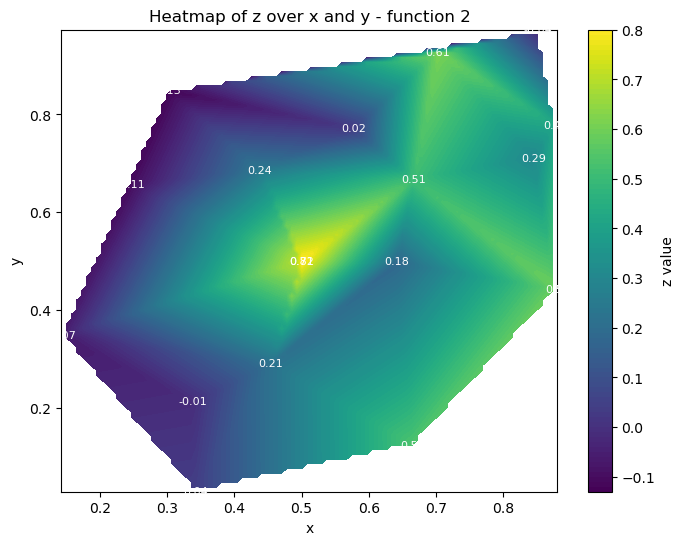

In [7]:
from scipy.interpolate import griddata

for i in range(1,3): #heatmaps of 2d functions
    ary_in, ary_out = get_function_data(i)
    x = ary_in[:, 0]
    y = ary_in[:, 1]
    z = ary_out

    if i==1:
        z = mbbo.functions.scale_f1(z) #apply scaling to f1 because of small values

    grid_x, grid_y = np.meshgrid(
        np.linspace(x.min(), x.max(), 100),
        np.linspace(y.min(), y.max(), 100)
    )

    # Interpolate the z values onto the grid
    grid_z = griddata((x, y), z, (grid_x, grid_y), method='linear')
    #grid_z = np.log10(-grid_z)

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    plt.contourf(grid_x, grid_y, grid_z, levels=100, cmap='viridis')
    plt.colorbar(label='z value')
    for xi, yi, zi in zip(x, y, z):
        plt.text(xi, yi, f'{zi:.2f}', color='white', fontsize=8, ha='center', va='center')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Heatmap of z over x and y - function {i}')
    plt.show()

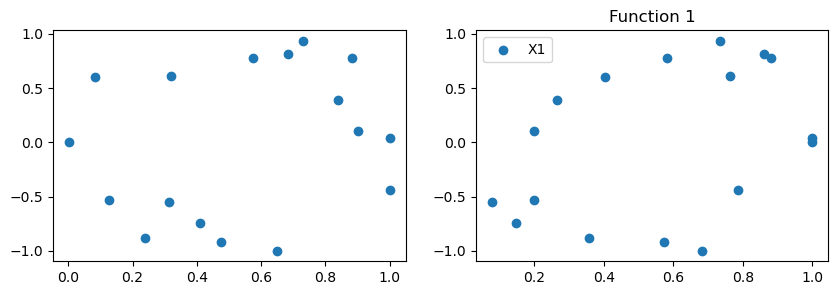

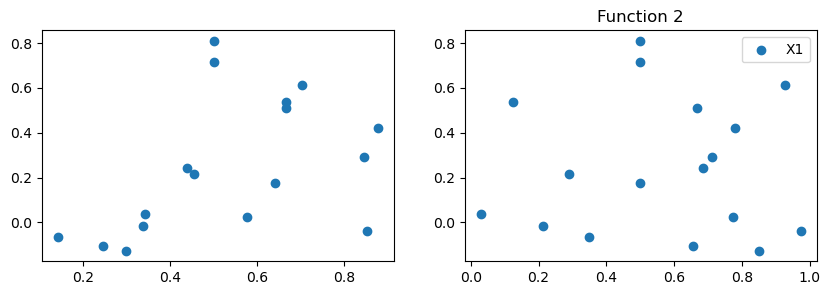

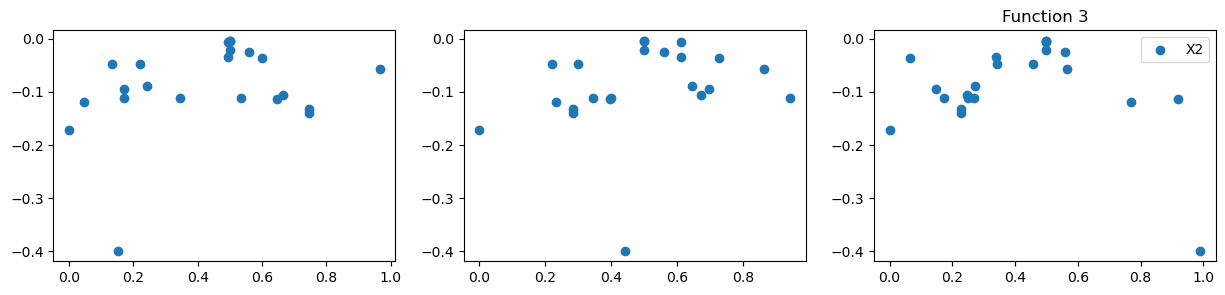

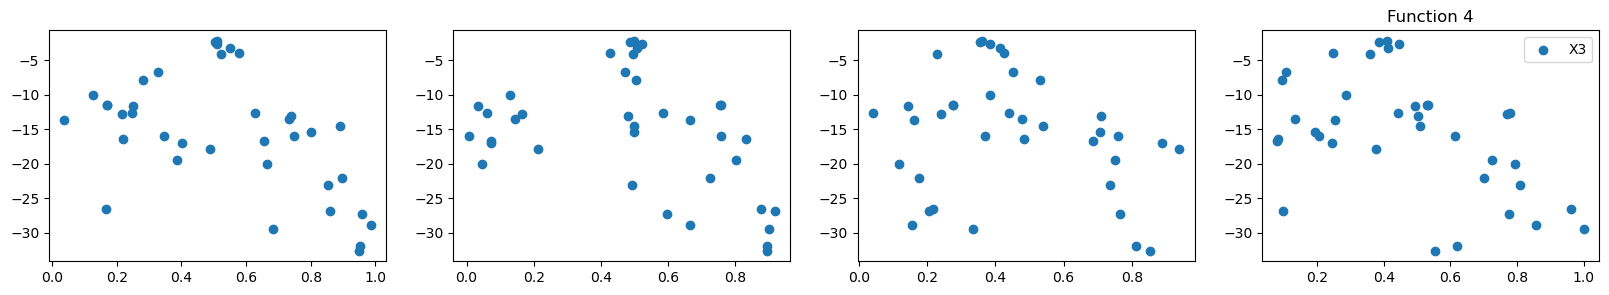

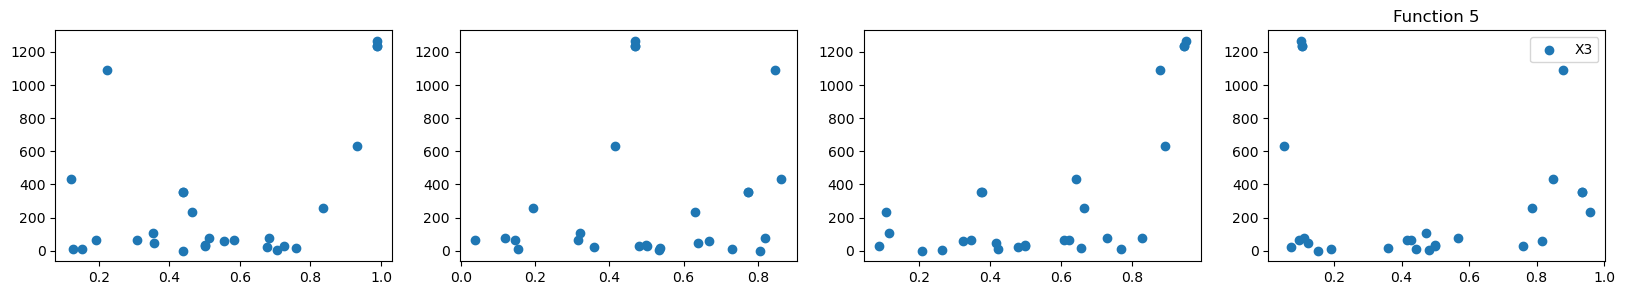

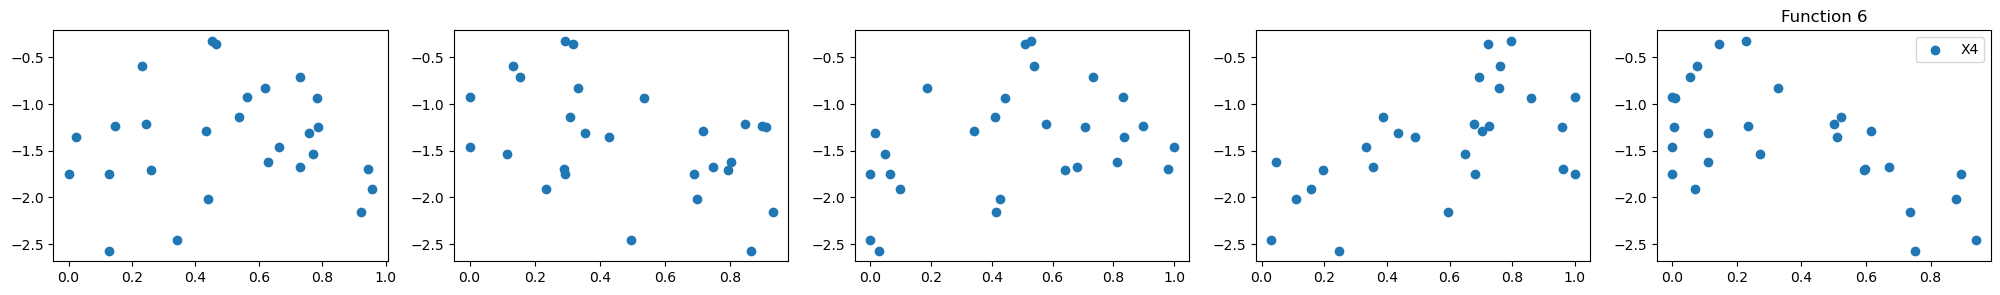

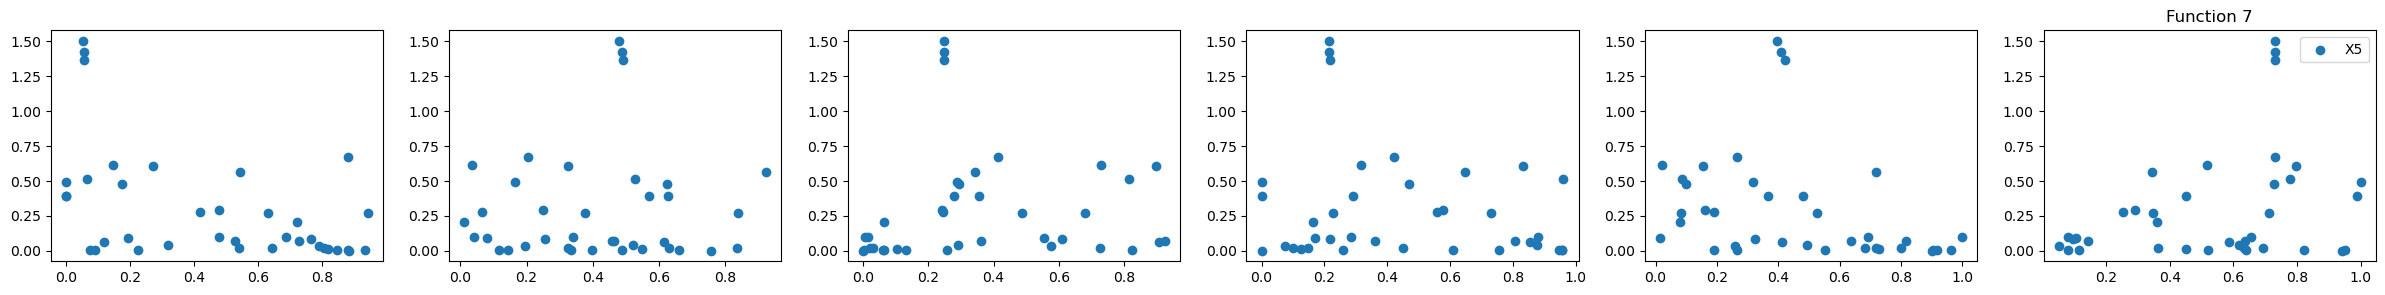

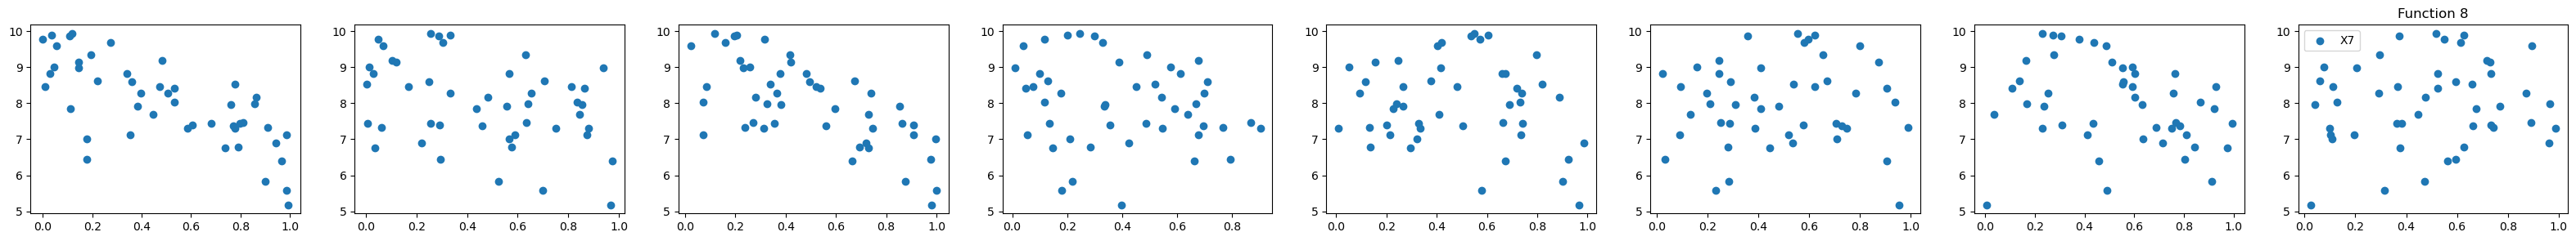

In [7]:



#Individual plot per parameter
for i in range(1,9):
    ary_in, ary_out = get_function_data(i)
    dimensions = ary_in.shape[1]
    fig, axes = plt.subplots(nrows=1, ncols=dimensions, figsize=(5 * dimensions, 3))
    if i==1:
        ary_out = scale_f1(ary_out) #apply scaling to f1 because of small values
    #fig.tight_layout()
    for x in range(0, dimensions):
        # sub = fig.add_subplot(1, dimensions, x+1)
        #sub.
        axes[x].scatter(ary_in[:, x], ary_out, label=f'X{x}')
        #sub.scatter(ary_in[:, x], ary_out, label=f'X{x}')
        #sub.xlabel(f'X{x}')
        #sub.ylabel('Output')
        # sub.title = f'Function {i} input {x}'
        #plt.savefig(f'../reports/figures/function_{i}_X{x}_vs_output.png')
    plt.title(f'Function {i}')    
    plt.legend()
    plt.show()

In [8]:
def create_n_dimensional_grid(dimensions, num_points = 1001):
    """
    Create a grid for n dimensions.
    
    Parameters:
    - dimensions: number of dimensions (n)
    - num_points: number of points along each axis
    
    Returns:
    - A 2D array of shape (n_points, n_dimensions) where each row is a point in the n-dimensional space.
    """
    # Create a list of n-dimensional grids in range 0-1
    grids = [np.linspace(0, 1, num_points) for _ in range(dimensions)]
    
    # Create the n-dimensional meshgrid and then stack the ravel-ed grids together
    meshgrid = np.meshgrid(*grids)
    
    # Flatten the meshgrid and stack it together to get a 2D array of shape (n_points, n_dimensions)
    X_grid = np.vstack([g.ravel() for g in meshgrid]).T
    
    return X_grid

In [29]:
from mbbo import kernels
import warnings

def choose_kernel(function_number):
    print(f"Function {f}")
    info_f = FunctionInfo(f)
    X,y = get_function_data(f)
    if(f == 1):
        y = scale_f1(y)
    ks = kernels.make_kernels_with_const(lengthscale_lb=info_f.lengthscale_bounds[0], lengthscale_ub=info_f.lengthscale_bounds[1])
    results = {}
    for name, kernel in ks.items():
        # Dictionary to store results
        gp = GaussianProcessRegressor(kernel=kernel, alpha=0.05, n_restarts_optimizer=10)

        gp.fit(X, y)
        
        # Compute Log Marginal Likelihood (MLL)
        mll = gp.log_marginal_likelihood_value_
        results[name] = {"MLL": mll, "Kernel": gp.kernel_}

        print(f"🔹 Kernel: {name}, MLL: {mll:.3f}, Optimized Kernel: {gp.kernel_}")

    # Select the best kernel based on MLL
    best_kernel_name = max(results, key=lambda k: results[k]["MLL"])
    best_kernel = results[best_kernel_name]["Kernel"]

    print(f"\n✅ Best Kernel: {best_kernel_name} with MLL: {results[best_kernel_name]['MLL']:.3f}")
    return best_kernel, results[best_kernel_name]['MLL']

for f in range(1, 9):
    best_k, mll = choose_kernel(f)
    print(f"Function {f} best kernel: {best_k} with MLL: {mll:.3f}")
    

Function 1
🔹 Kernel: RBF, MLL: -17.283, Optimized Kernel: 0.63**2 * RBF(length_scale=0.0128)
🔹 Kernel: Matern_1.5, MLL: -17.283, Optimized Kernel: 0.63**2 * Matern(length_scale=0.000146, nu=1.5)


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


🔹 Kernel: Matern_2.5, MLL: -17.283, Optimized Kernel: 0.63**2 * Matern(length_scale=0.0001, nu=2.5)
🔹 Kernel: RationalQuadratic, MLL: -17.283, Optimized Kernel: 0.63**2 * RationalQuadratic(alpha=0.955, length_scale=0.00466)
🔹 Kernel: DotProduct, MLL: -60.633, Optimized Kernel: DotProduct(sigma_0=0.0041) + 0.565**2

✅ Best Kernel: RationalQuadratic with MLL: -17.283
Function 1 best kernel: 0.63**2 * RationalQuadratic(alpha=0.955, length_scale=0.00466) with MLL: -17.283
Function 2
🔹 Kernel: RBF, MLL: -4.353, Optimized Kernel: 0.27**2 * RBF(length_scale=0.395)
🔹 Kernel: Matern_1.5, MLL: -4.078, Optimized Kernel: 0.269**2 * Matern(length_scale=0.271, nu=1.5)
🔹 Kernel: Matern_2.5, MLL: -4.226, Optimized Kernel: 0.267**2 * Matern(length_scale=0.233, nu=2.5)
🔹 Kernel: RationalQuadratic, MLL: -3.723, Optimized Kernel: 0.288**2 * RationalQuadratic(alpha=0.16, length_scale=0.0544)
🔹 Kernel: DotProduct, MLL: -5.454, Optimized Kernel: DotProduct(sigma_0=1e-05) + 0.00316**2

✅ Best Kernel: Rational

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 40.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


🔹 Kernel: RBF, MLL: 10.094, Optimized Kernel: 0.0764**2 * RBF(length_scale=40)


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 40.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 40.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


🔹 Kernel: Matern_1.5, MLL: 10.093, Optimized Kernel: 0.0764**2 * Matern(length_scale=40, nu=1.5)
🔹 Kernel: Matern_2.5, MLL: 10.094, Optimized Kernel: 0.0764**2 * Matern(length_scale=40, nu=2.5)


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 40.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: T

🔹 Kernel: RationalQuadratic, MLL: 10.094, Optimized Kernel: 0.0764**2 * RationalQuadratic(alpha=1e-05, length_scale=40)
🔹 Kernel: DotProduct, MLL: 5.221, Optimized Kernel: DotProduct(sigma_0=1e-05) + 0.00316**2

✅ Best Kernel: RationalQuadratic with MLL: 10.094
Function 3 best kernel: 0.0764**2 * RationalQuadratic(alpha=1e-05, length_scale=40) with MLL: 10.094
Function 4
🔹 Kernel: RBF, MLL: -85.703, Optimized Kernel: 27.7**2 * RBF(length_scale=0.925)
🔹 Kernel: Matern_1.5, MLL: -83.203, Optimized Kernel: 79.9**2 * Matern(length_scale=5.98, nu=1.5)
🔹 Kernel: Matern_2.5, MLL: -80.861, Optimized Kernel: 50.3**2 * Matern(length_scale=2.4, nu=2.5)
🔹 Kernel: RationalQuadratic, MLL: -76.317, Optimized Kernel: 60**2 * RationalQuadratic(alpha=0.0607, length_scale=3.51)
🔹 Kernel: DotProduct, MLL: -14122.194, Optimized Kernel: DotProduct(sigma_0=0.214) + 1.74**2

✅ Best Kernel: RationalQuadratic with MLL: -76.317
Function 4 best kernel: 60**2 * RationalQuadratic(alpha=0.0607, length_scale=3.51) wi

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


🔹 Kernel: RBF, MLL: -178.058, Optimized Kernel: 316**2 * RBF(length_scale=0.107)


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


🔹 Kernel: Matern_1.5, MLL: -177.229, Optimized Kernel: 316**2 * Matern(length_scale=0.182, nu=1.5)


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


🔹 Kernel: Matern_2.5, MLL: -177.571, Optimized Kernel: 316**2 * Matern(length_scale=0.139, nu=2.5)


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


🔹 Kernel: RationalQuadratic, MLL: -175.019, Optimized Kernel: 316**2 * RationalQuadratic(alpha=0.327, length_scale=0.0942)


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


🔹 Kernel: DotProduct, MLL: -18347368.507, Optimized Kernel: DotProduct(sigma_0=1e+05) + 316**2

✅ Best Kernel: RationalQuadratic with MLL: -175.019
Function 5 best kernel: 316**2 * RationalQuadratic(alpha=0.327, length_scale=0.0942) with MLL: -175.019
Function 6
🔹 Kernel: RBF, MLL: -20.942, Optimized Kernel: 2.27**2 * RBF(length_scale=1.36)
🔹 Kernel: Matern_1.5, MLL: -14.984, Optimized Kernel: 2.31**2 * Matern(length_scale=3.51, nu=1.5)
🔹 Kernel: Matern_2.5, MLL: -16.426, Optimized Kernel: 2.2**2 * Matern(length_scale=2.25, nu=2.5)
🔹 Kernel: RationalQuadratic, MLL: -12.269, Optimized Kernel: 2.58**2 * RationalQuadratic(alpha=0.0417, length_scale=3.04)
🔹 Kernel: DotProduct, MLL: -33.766, Optimized Kernel: DotProduct(sigma_0=3.23e-05) + 1.34**2

✅ Best Kernel: RationalQuadratic with MLL: -12.269
Function 6 best kernel: 2.58**2 * RationalQuadratic(alpha=0.0417, length_scale=3.04) with MLL: -12.269
Function 7
🔹 Kernel: RBF, MLL: -11.711, Optimized Kernel: 0.321**2 * RBF(length_scale=0.355)

c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


🔹 Kernel: RationalQuadratic, MLL: -22.258, Optimized Kernel: 3.05**2 * RationalQuadratic(alpha=1e+05, length_scale=2.38)
🔹 Kernel: DotProduct, MLL: -51.021, Optimized Kernel: DotProduct(sigma_0=11) + 0.0435**2

✅ Best Kernel: RBF with MLL: -22.258
Function 8 best kernel: 3.05**2 * RBF(length_scale=2.38) with MLL: -22.258


In [9]:
# Gaussian Process Acquisition Function (Upper Confidence Bound)
def ucb_acquisition(x, model, kappa=2.0):
    """
    UCB acquisition function for Bayesian Optimization.
    
    Parameters:
    - x: Point at which to evaluate the acquisition function.
    - model: GaussianProcessRegressor model.
    - kappa: Controls the exploration vs exploitation trade-off.
    
    Returns:
    - UCB acquisition value at point x.
    """
    # Predict the mean and standard deviation
    mean, std = model.predict(x.reshape(1, -1), return_std=True)
    
    # UCB acquisition function
    return mean + kappa * std

def lcb_acquisition(x, model, kappa=2.0):
    mean, std = model.predict(x.reshape(1, -1), return_std=True)
    return mean - kappa * std

# Function to suggest the next query point
def suggest_next_point(bounds, function_number, model, kappa=2.0):
    """
    Suggest the next point to query using Bayesian Optimization with Gaussian Process.
    
    Parameters:
    - X_existing: Array of input points already observed (n_samples, n_features).
    - Y_existing: Array of corresponding output values (n_samples,).
    - bounds: Bounds for each input dimension (n_features, 2).
    - model: Pre-trained GaussianProcessRegressor model (if available).
    - kappa: Exploration-exploitation trade-off parameter for UCB.
    
    Returns:
    - Next input point to query.
    """

    # Define the acquisition function to minimize (negative UCB)
    def acquisition_wrapper(x):
        if function_number in [1,2,5,7,8]: #maximise
            return -ucb_acquisition(x, model, kappa)
        elif function_number == 4: # minimise
            return lcb_acquisition(x, model, kappa) 
        else:
            # closest to 0. Get highest abs of (ucb or lcb) and minimize that
            return max(abs(lcb_acquisition(x, model, kappa)), abs(ucb_acquisition(x, model, kappa)))  # Minimize the negative of the acquisition function
    
    # Minimize the acquisition function to find the next point
    start_point = np.random.uniform(bounds[:, 0], bounds[:, 1])
    #print (f"Start point = {start_point}")
    res = optimize.minimize(acquisition_wrapper, start_point, bounds=bounds, method='L-BFGS-B')
    
    # Return the next query point
    return res.x

def at_bound(x):
    if (0 in x) or (1 in x):
        return True
    return False

# Suggest next points for each function
for i in range(1,9):
    ary_in, ary_out = get_function_data(i)
    in_bounds = np.array([[0.0, 1.0]] * ary_in.shape[1])

    # fit gaussian process surrogate function
    kernel = RBF(length_scale=0.1, length_scale_bounds='fixed')
    #kernel = RationalQuadratic(length_scale=0.1, alpha=1.0)

    noise_assumption = 1e-1 # noise assumption, a hyper-parameter
    surrogate = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)

    surrogate.fit(ary_in, ary_out)

    next_point = [0]
    while at_bound(next_point):
        next_point = suggest_next_point(in_bounds, i, surrogate, kappa=2)
        #print(f"Function {i} Considering next point: {next_point})")
    submit = format_for_submission(next_point)
    print (f"Function {i} Next point to submit: {submit}")    

Function 1 Next point to submit: 0.589268-0.342622
Function 2 Next point to submit: 0.824035-0.079646
Function 3 Next point to submit: 0.600083-0.725167-0.066014
Function 4 Next point to submit: 0.464976-0.174456-0.924952-0.340886
Function 5 Next point to submit: 0.501053-0.499881-0.499974-0.499538
Function 6 Next point to submit: 0.967545-0.726280-0.377213-0.383213-0.185893
Function 7 Next point to submit: 0.170145-0.096381-0.771796-0.446311-0.051615-0.495672
Function 8 Next point to submit: 0.580581-0.011923-0.217732-0.698483-0.274536-0.376964-0.041655-0.074212


In [10]:
#using skopt

from skopt import gp_minimize
from skopt.space import Real
from sklearn.gaussian_process.kernels import Matern

def surrogate_function(inputs):
    
    # Predict using the Gaussian Process surrogate model
    y_pred, stdev = gp.predict(np.atleast_2d(inputs), return_std=True)
    return y_pred[0]  # Minimizing

def make_search_space(dimensions):
    
    search_space = [Real(0.0, 1.0, name=f'x{i+1}') for i in range(dimensions)]
    return search_space

# [abs y/n], [-1 for maximise, 1 for minimise], acq_func, kappa
optimise_params = [
    [0, 1, "LCB", 10], #f1 - maximise exploration
    [0, 1, "LCB", 2], #f2 - maximise exploration - 
    [0, 1, "EI", 0], #f3 - measuring adverse reaction to drug. Surely 0 for all ingredients would minimise adverse reaction!
    [1, 1, "EI", 5], #f2 - minimize absolute value - maximise exploration - ideally would be LCB but that is returning the bounds
    [0, -1, "EI", 0], #f5 - unimodal (maximize exploitation) - maximise yield
    [1, 1, "EI", 0], #f6 - cake - minimise absolute value
    [0, 1, "LCB", 1], #f7
    [0, 1, "EI", 0] #f8
    ]

noise_level = 0.1

#for i in range(1,9):
for i in [7]:
    ary_in, ary_out = get_function_data(i)
    print("Shape of ary_in:", ary_in.shape)

    search_space = make_search_space(ary_in.shape[1])

    # Check if ary_in dimensions match the search space
    assert ary_in.shape[1] == len(search_space), (
        f"Input dimensions ({ary_in.shape[1]}) do not match the search space dimensions ({len(search_space)})."
    )

    kernel = Matern(nu=2.5)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

    gp.fit(ary_in, ary_out)

    p = optimise_params[i-1]
    ary_out_prepared = ary_out * p[1] # if we should maximise, negate the output values before minimising
    if p[0]: #Use absolute vals where appropriate
        ary_out_prepared = np.abs(ary_out_prepared)
    
    res = gp_minimize(
    func=surrogate_function,   # The objective function to minimize
    dimensions=search_space,  # The search space
    #acq_func="EI",           # Acquisition function (Expected Improvement)
    acq_func=p[2],
    kappa= p[3],    # High kappa favors exploration
    n_calls=ary_in.shape[0] * 2,               # Total number of queries allowed (including initial samples)
    x0=[list(x) for x in ary_in],             # Initial input samples
    y0=ary_out # Initial output samples (negated for maximization)
    )
    print(f"Function {i}")
    print("Best input values found:", res.x)
    print("Best output value observed:", res.fun)

    # Suggest the next point to evaluate
    suggested = np.array(res.x_iters[-1])
    print("Suggested next inputs to try:", format_for_submission(suggested))



Shape of ary_in: (37, 6)
Function 7
Best input values found: [0.07365462086923899, 0.8498740915086291, 0.4913126433500312, 0.07542155299456377, 0.8111789389350167, 1.0]
Best output value observed: -0.4216565999481503
Suggested next inputs to try: 0.073655-0.849874-0.491313-0.075422-0.811179-0.999999
